# The Fourier transform of an interferogram

In [1]:
import numpy as np
import pylab as pl

## Simulation of an emission line (monochromatic) interferogram

* $\sigma$: wavenumber (cm$^{-1}$)
* $\phi$: phase (rad)
* $x$: OPD (cm)

$I(x) = \cos(2 x \sigma \pi + \phi)$

In [2]:
# defined in orb.utils.sim.line_interf
def line_interf(step_nb, sigma, phi=0):
    if sigma > step_nb / 2.: raise ValueError('Sigma must be < step_nb/2')
    x = np.arange(step_nb, dtype=float) / (step_nb-1) # x axis
    a = np.cos(x*sigma*2.* np.pi + phi) / 2. + 0.5 # interferogram I(x)
    return a

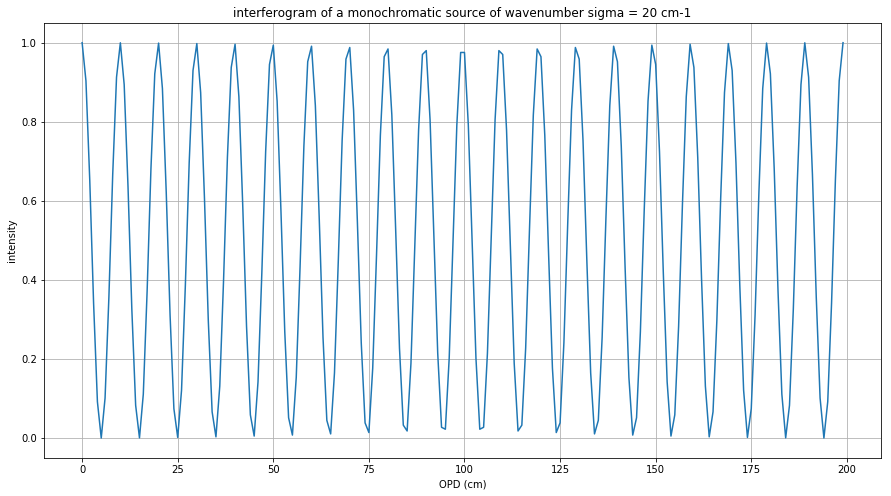

In [3]:
step_nb = 200
sigma = 20
interf = line_interf(step_nb, sigma)
pl.figure(figsize=(15,8))
pl.plot(interf)
pl.xlabel('OPD (cm)')
pl.ylabel('intensity')
pl.title('interferogram of a monochromatic source of wavenumber sigma = {} cm-1'.format(sigma))
pl.grid()

## A Fourier transformed emission line spectrum

$S(\sigma) = \int_{-\infty}^{+\infty} I(x) \exp(-2i\pi\sigma x)\,\text{d}x$

Note that the **whole** interferogram is multiplied by $\sim\exp(-ix) = \cos(x) - i\sin(x)$ to obtain the spectrum at any given wavenumber $\sigma$. To obtain the complete spectrum this operation must be repeated for all the channels of the output spectrum.


In [4]:
# defined in orb.utils.sim.fft
def fft(interf, zp_coeff=1, apod=None):
    """
    Basic Fourier Transform with zero-padding.

    Useful to compute a quick assumption-less FFT.

    ZPD is assumed to be on the first sample of the interferogram
    
    :param interf: interferogram

    :param zp_coeff: Zero-padding coefficient

    :return: axis, complex interferogram FFT
    """
    step_nb = interf.shape[0]

    # remove mean
    interf = np.copy(interf) - np.nanmean(interf)
        
    # zero padding
    zp_nb = step_nb * zp_coeff * 2
    zp_interf = np.zeros(zp_nb, dtype=float)
    zp_interf[:step_nb] = interf

    # fft
    interf_fft = np.fft.fft(zp_interf)
    interf_fft = interf_fft[:interf_fft.shape[0]/2+1]
    
    # define output axis
    axis = np.linspace(0, (step_nb - 1)/2., interf_fft.shape[0])
    return axis, interf_fft

/home/thomas/.virtualenvs/orb/local/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


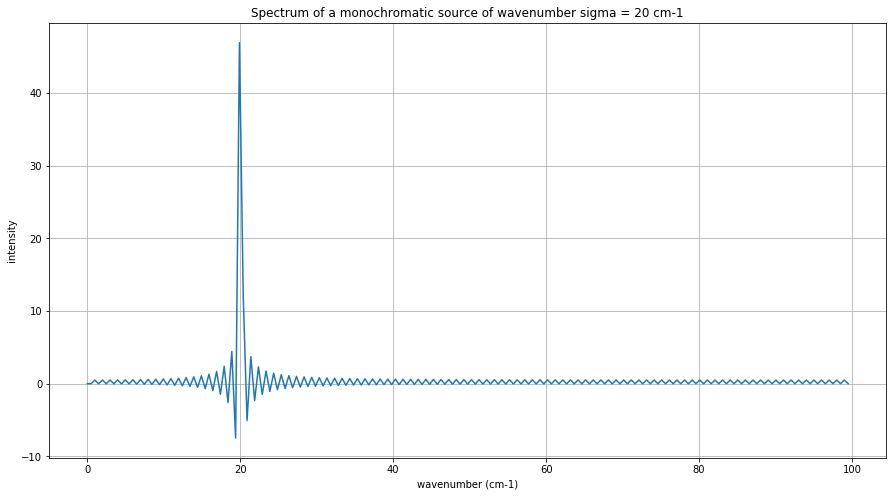

In [5]:
axis, spectrum = fft(interf)
pl.figure(figsize=(15,8))
pl.plot(axis, spectrum)
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('intensity')
pl.title('Spectrum of a monochromatic source of wavenumber sigma = {} cm-1'.format(sigma))
pl.grid()

/home/thomas/.virtualenvs/orb/local/lib/python2.7/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


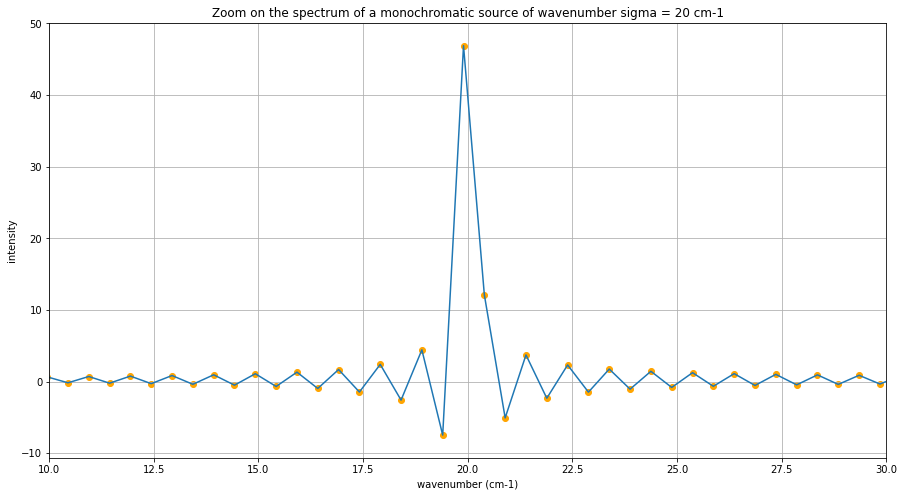

In [6]:
pl.figure(figsize=(15,8))
pl.plot(axis, spectrum)
pl.scatter(axis, spectrum, color='orange')
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('intensity')
pl.title('Zoom on the spectrum of a monochromatic source of wavenumber sigma = {} cm-1'.format(sigma))
pl.xlim([sigma-10, sigma+10])
pl.grid()

## higher resolution of the spectrum with the same interferogram ?

The spectrum shown above is clearly displayed with the smallest possible resolution. But, if we look at the Fourier equation we can compute the spectrum everywhere. We can thus get as many samples as we need on the output spectrum.


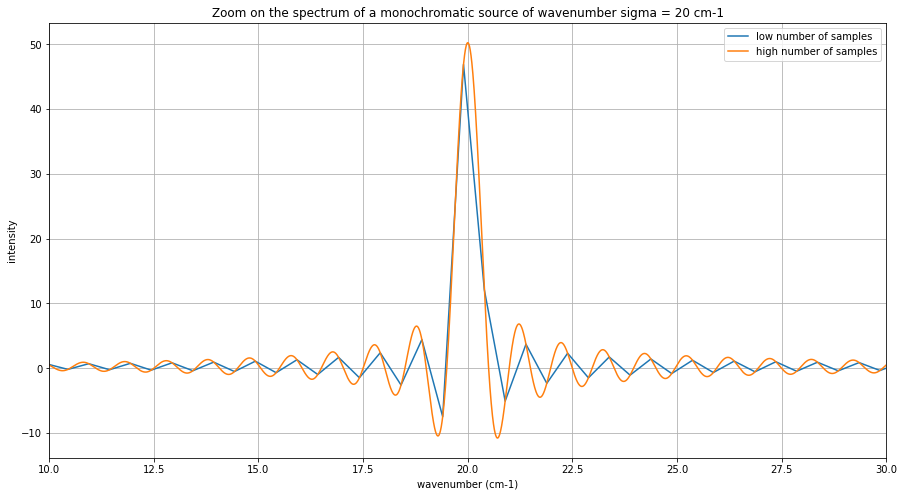

In [7]:
lr_axis, lr_spectrum = fft(interf, zp_coeff=1)

hr_axis, hr_spectrum = fft(interf, zp_coeff=100)
pl.figure(figsize=(15,8))
pl.plot(lr_axis, lr_spectrum, label='low number of samples')
pl.plot(hr_axis, hr_spectrum, label='high number of samples')
pl.xlabel('wavenumber (cm-1)')
pl.ylabel('intensity')
pl.title('Zoom on the spectrum of a monochromatic source of wavenumber sigma = {} cm-1'.format(sigma))
pl.xlim([sigma-10, sigma+10])
pl.legend()
pl.grid()

**do we have a better resolution** or more information ? If we fit noth spectra, are we going to have more precision on the parameter estimate with the high sampled spectrum ?

**The answer is (sadly) : no !**

* The resolution of an emission-line is defined by its FWHM (here it is the same for both spectra).

* The precision of the parameter estimate of an emission line is limited by its resolution and the **noise** which is not reduced by computing more samples from the same interferogram (**samples are correlated i.e. the noise is correlated i.e. samples are not independant**). This would not be the case with independant measurements (see below).

## adding independant samples gives more precision on the parameter estimates

In [32]:
import scipy
def model(xdata, a, b, c):
    return a + np.exp(- (xdata - c)**2 / b**2)

a = -0.09+/-0.03
b = 0.13+/-0.01


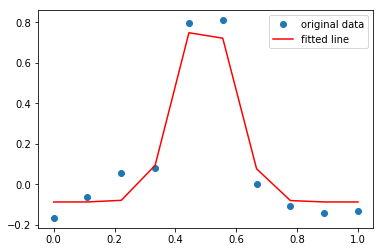

In [45]:
x = np.linspace(0, 1, 10)
y = model(x, 0, 0.1, 0.5) + np.random.standard_normal(x.size) * 0.1
popt, pcov = scipy.optimize.curve_fit(model, x, y)
perr = np.sqrt(np.diag(pcov))
print 'a = {:.2f}+/-{:.2f}'.format(popt[0], perr[0])
print 'b = {:.2f}+/-{:.2f}'.format(popt[1], perr[1])

pl.plot(x, y, 'o', label='original data')
pl.plot(x, model(x, *popt), 'r', label='fitted line')
pl.legend()

a = -0.02+/-0.01
b = 0.10+/-0.00


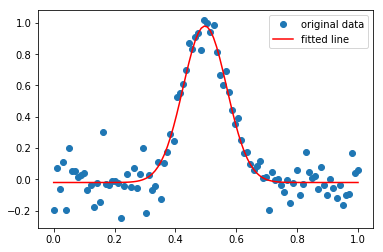

In [46]:
x = np.linspace(0, 1, 100)
y = model(x, 0, 0.1, 0.5) + np.random.standard_normal(x.size) * 0.1
popt, pcov = scipy.optimize.curve_fit(model, x, y)
perr = np.sqrt(np.diag(pcov))
print 'a = {:.2f}+/-{:.2f}'.format(popt[0], perr[0])
print 'b = {:.2f}+/-{:.2f}'.format(popt[1], perr[1])

pl.plot(x, y, 'o', label='original data')
pl.plot(x, model(x, *popt), 'r', label='fitted line')
pl.legend()